# 🩺 Face Mask Detection using YOLOv8

### 👋 Overview
This notebook demonstrates the process of building a **real-time face mask detection system** using the **YOLOv8 object detection model**.  
We download the dataset from Kaggle, convert it into YOLO-compatible format, split it into train/validation sets, and prepare it for model training and deployment.


## Importing Face Mask Dataset from Kaggle
We’ll use `kagglehub` to download the **Face Mask Detection dataset** by Andrew MVD directly into our workspace.


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/face-mask-detection")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'face-mask-detection' dataset.
Path to dataset files: /kaggle/input/face-mask-detection


## Verifying Dataset Directory Structure
After downloading, verify that the dataset folders (`annotations/` and `images/`) exist and contain the correct number of files.


In [4]:
import os

print(os.listdir(path))  # should show ['annotations', 'images']
print("Annotations:", len(os.listdir(os.path.join(path, "annotations"))))
print("Images:", len(os.listdir(os.path.join(path, "images"))))

['annotations', 'images']
Annotations: 853
Images: 853


## Exploratory Data Analysis Section
Reads all Pascal VOC XML annotation files.

Extracts object class names like with_mask, without_mask, mask_weared_incorrect.

Plots their frequency for dataset balance.

Displays random sample images for visual insight

                   Class  Unique_Images
0              with_mask            768
1  mask_weared_incorrect             97
2           without_mask            286


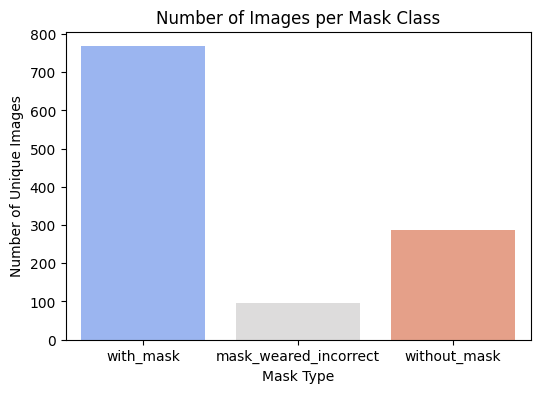

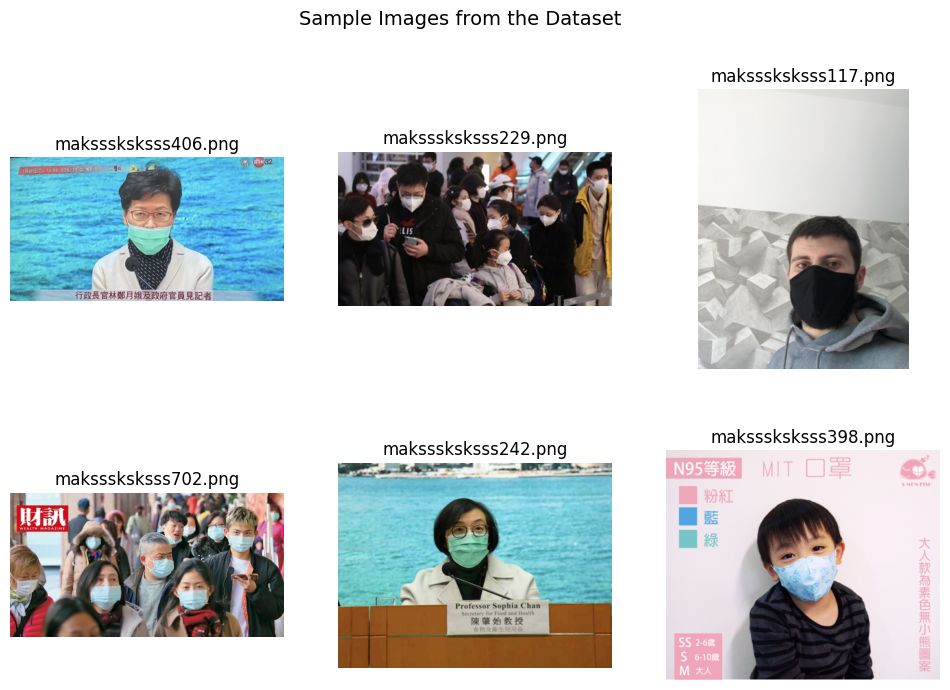

In [17]:
# Exploratory Data Analysis ---
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import xml.etree.ElementTree as ET

# Define dataset paths
annotations_dir = os.path.join(path, "annotations")
images_dir = os.path.join(path, "images")

# Track unique images containing each class
class_to_images = defaultdict(set)

for xml_file in os.listdir(annotations_dir):
    if xml_file.endswith(".xml"):
        tree = ET.parse(os.path.join(annotations_dir, xml_file))
        root = tree.getroot()
        filename = root.find("filename").text

        for obj in root.findall("object"):
            name = obj.find("name").text
            class_to_images[name].add(filename)

# Convert to DataFrame: count unique images per class
df = pd.DataFrame(
    [(cls, len(imgs)) for cls, imgs in class_to_images.items()],
    columns=["Class", "Unique_Images"]
)
print(df)

# Plot distribution of unique images per class
plt.figure(figsize=(6, 4))
sns.barplot(x="Class", y="Unique_Images", data=df, palette="coolwarm")
plt.title("Number of Images per Mask Class")
plt.xlabel("Mask Type")
plt.ylabel("Number of Unique Images")
plt.show()

# Visualize a few sample images
import random
import cv2
import matplotlib.pyplot as plt

sample_images = random.sample(os.listdir(images_dir), 6)
plt.figure(figsize=(12, 8))
for i, img_name in enumerate(sample_images):
    img = cv2.imread(os.path.join(images_dir, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_name)
plt.suptitle("Sample Images from the Dataset", fontsize=14)
plt.show()


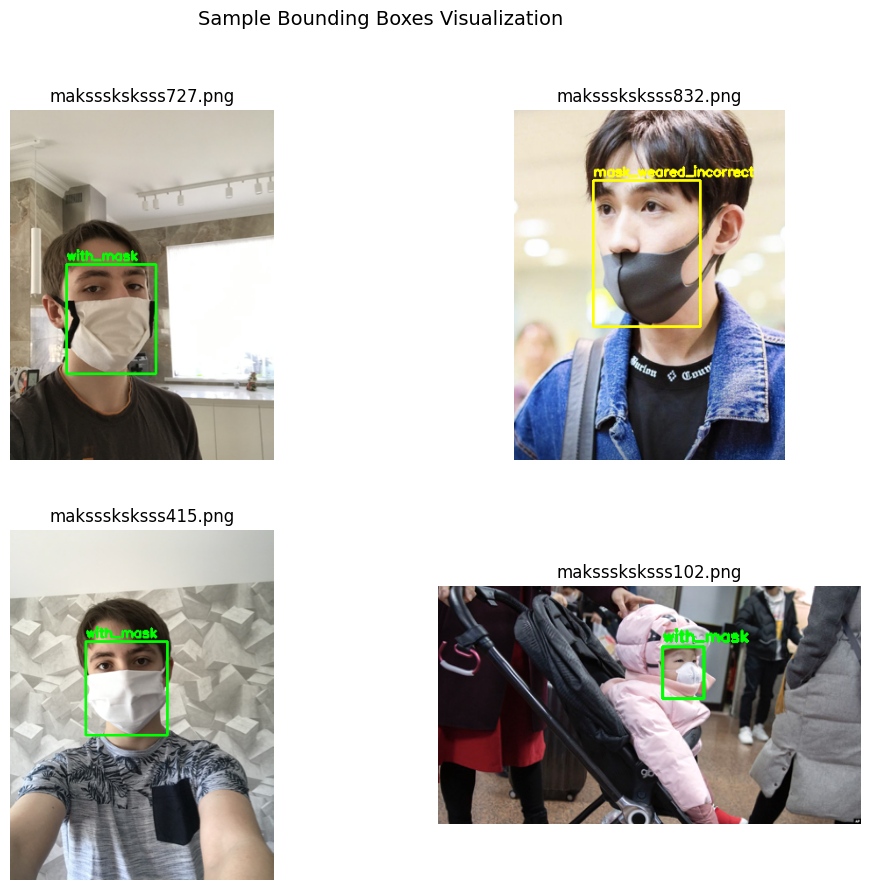

In [18]:
# --- Visualize Bounding Boxes on Sample Images ---
import cv2
import xml.etree.ElementTree as ET
import random
import matplotlib.pyplot as plt

# Define dataset directories again if needed
annotations_dir = os.path.join(path, "annotations")
images_dir = os.path.join(path, "images")

# Select random annotated images
sample_xmls = random.sample([f for f in os.listdir(annotations_dir) if f.endswith(".xml")], 4)

plt.figure(figsize=(12, 10))
for i, xml_file in enumerate(sample_xmls):
    tree = ET.parse(os.path.join(annotations_dir, xml_file))
    root = tree.getroot()

    filename = root.find("filename").text
    image_path = os.path.join(images_dir, filename)

    # Read image
    img = cv2.imread(image_path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Draw bounding boxes
    for obj in root.findall("object"):
        name = obj.find("name").text
        bndbox = obj.find("bndbox")
        xmin = int(float(bndbox.find("xmin").text))
        ymin = int(float(bndbox.find("ymin").text))
        xmax = int(float(bndbox.find("xmax").text))
        ymax = int(float(bndbox.find("ymax").text))

        color = (0, 255, 0) if name == "with_mask" else (255, 0, 0) if name == "without_mask" else (255, 255, 0)
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, 2)
        cv2.putText(img, name, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Plot image with bounding boxes
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(filename)
plt.suptitle("Sample Bounding Boxes Visualization", fontsize=14)
plt.show()


## Converting Annotations to YOLO Format
The dataset annotations are in **Pascal VOC XML** format.  
We’ll convert them into YOLO-compatible text files (`.txt`), each containing class labels and normalized bounding box coordinates.


In [6]:
import os
import xml.etree.ElementTree as ET

# Define paths
annotations_dir = "/kaggle/input/face-mask-detection/annotations"  # Folder containing XML files
labels_dir = "/content/labels"            # Folder to save YOLO TXT files
os.makedirs(labels_dir, exist_ok=True)

# Class name to label mapping
class_mapping = {
    "with_mask": 0,
    "without_mask": 1,
    "mask_weared_incorrect" : 2
}

def convert_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Get image size
    size = root.find('size')
    img_width = float(size.find('width').text)
    img_height = float(size.find('height').text)

    yolo_lines = []

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        if class_name not in class_mapping:
            continue  # skip unknown classes

        class_id = class_mapping[class_name]

        bndbox = obj.find('bndbox')
        xmin = float(bndbox.find('xmin').text)
        ymin = float(bndbox.find('ymin').text)
        xmax = float(bndbox.find('xmax').text)
        ymax = float(bndbox.find('ymax').text)

        # Compute YOLO format bounding box
        x_center = (xmin + xmax) / 2.0 / img_width
        y_center = (ymin + ymax) / 2.0 / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height

        yolo_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    # Write to corresponding TXT file
    txt_filename = os.path.splitext(os.path.basename(xml_file))[0] + ".txt"
    txt_path = os.path.join(labels_dir, txt_filename)
    with open(txt_path, "w") as f:
        f.write("\n".join(yolo_lines))

# Process all XML files
for filename in os.listdir(annotations_dir):
    if filename.endswith(".xml"):
        convert_annotation(os.path.join(annotations_dir, filename))

print("Conversion completed!")


Conversion completed!


## Splitting Dataset into Train and Validation Sets
To train the YOLO model effectively, we’ll split the dataset into **training (80%)** and **validation (20%)** sets while maintaining class balance.


In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Paths
images_dir = '/kaggle/input/face-mask-detection/images'
labels_dir = '/content/labels'

# Output structure
base_output = '/content/dataset'
train_img_dir = os.path.join(base_output, 'images/train')
val_img_dir = os.path.join(base_output, 'images/val')
train_lbl_dir = os.path.join(base_output, 'labels/train')
val_lbl_dir = os.path.join(base_output, 'labels/val')

# Create directories
for d in [train_img_dir, val_img_dir, train_lbl_dir, val_lbl_dir]:
    os.makedirs(d, exist_ok=True)

# Collect all image files
image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Split train/val
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Function to copy images and matching labels
def copy_files(file_list, src_img_dir, src_lbl_dir, dst_img_dir, dst_lbl_dir):
    for file in tqdm(file_list):
        img_src = os.path.join(src_img_dir, file)
        lbl_src = os.path.join(src_lbl_dir, os.path.splitext(file)[0] + '.txt')

        # Copy image
        shutil.copy(img_src, dst_img_dir)

        # Copy label if it exists
        if os.path.exists(lbl_src):
            shutil.copy(lbl_src, dst_lbl_dir)

# Copy training data
print("Copying training data...")
copy_files(train_files, images_dir, labels_dir, train_img_dir, train_lbl_dir)

# Copy validation data
print("Copying validation data...")
copy_files(val_files, images_dir, labels_dir, val_img_dir, val_lbl_dir)

print("\n✅ Dataset split complete!")
print(f"Train images: {len(train_files)}, Val images: {len(val_files)}")


Copying training data...


100%|██████████| 682/682 [00:06<00:00, 109.04it/s]


Copying validation data...


100%|██████████| 171/171 [00:01<00:00, 99.83it/s] 


✅ Dataset split complete!
Train images: 682, Val images: 171


## Creating the YAML file
To send the data to YOLO model effectively, we’ll make a dataset.yaml file.


In [8]:
import yaml
import os

# Base dataset path (where your images and labels folders are)
base_path = '/content/dataset'

# Define YAML structure
data = {
    'train': os.path.join(base_path, 'images/train'),
    'val': os.path.join(base_path, 'images/val'),
    'nc': 3,  # <-- change this to your number of classes
    'names': ['with_mask', 'without_mask', 'mask_weared_incorrect']  # <-- change class names accordingly
}

# Save YAML file
yaml_path = os.path.join(base_path, 'dataset.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(data, f, sort_keys=False)

print(f"✅ dataset.yaml created at: {yaml_path}")


✅ dataset.yaml created at: /content/dataset/dataset.yaml


## Verifying the YAML File

In [9]:
import yaml

with open('/content/dataset/dataset.yaml') as f:
    data = yaml.safe_load(f)

print(data)


{'train': '/content/dataset/images/train', 'val': '/content/dataset/images/val', 'nc': 3, 'names': ['with_mask', 'without_mask', 'mask_weared_incorrect']}


## Setting Up YOLOv8 Environment
Install and import required libraries
- `ultralytics` (for YOLOv8)

In [10]:
!pip install ultralytics --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.7 MB/s eta 0:00:00


## Verifying GPU availability

In [11]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


CUDA available: True
GPU name: Tesla T4



## Training YOLOv8 Model
Train the model on our prepared dataset using **Ultralytics YOLOv8** with appropriate hyperparameters (epochs, batch size, image size, etc.).


In [12]:
from ultralytics import YOLO

# Load a YOLOv8 model (choose size: n, s, m, l, or x)
# 'n' = nano (fastest), 's' = small (good balance), 'm' = medium (more accurate)
model = YOLO('yolov8s.pt')  # you can try yolov8n.pt for faster runs

# Train
model.train(
    data='/content/dataset/dataset.yaml',
    epochs=110,          # number of training epochs
    augment = True,
    mosaic = 1,
    mixup = 0.1,
    imgsz=640,          # image size (default for YOLOv8)
    batch=16,           # fits well in 16GB GPU; use 8 if VRAM is limited
    patience=20,
    workers=2,          # lower for Kaggle notebook stability
    name='mask_detection_yolov8s',  # output folder name
    project='/content/runs', # where results will be saved
    pretrained=True,    # start from pretrained COCO weights
    device=0            # use GPU
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.220 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=110, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78241c58cb90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

## Evaluating the model

In [13]:
model.val(data="/content/dataset/dataset.yaml")


Ultralytics 8.3.220 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3798.3±832.4 MB/s, size: 506.8 KB)
val: Scanning /content/dataset/labels/val.cache... 171 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 171/171 336.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 1.5it/s 7.1s
                   all        171        883      0.893       0.76      0.862      0.566
             with_mask        156        686      0.881      0.914      0.939       0.65
          without_mask         57        162      0.871      0.793      0.863      0.532
 mask_weared_incorrect         24         35      0.927      0.571      0.783      0.516
Speed: 4.1ms preprocess, 15.0ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to /content/runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78238017fc50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

## Visualization After Model Results
Loads YOLOv8 training logs and plots training/validation loss, precision, recall, and mAP trends.

Produces a confusion matrix showing true vs. predicted class performance

KeyError: 'metrics/mAP50'

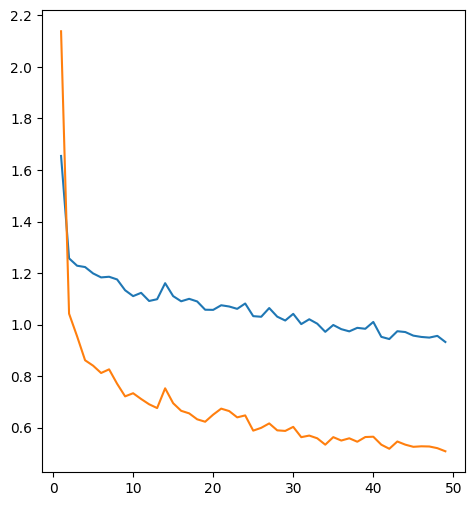

In [16]:
# --- Result Visualization ---
from ultralytics import YOLO
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pandas as pd

results_dir = "/content/runs/mask_detection_yolov8s/results.csv"
if os.path.exists(results_dir):
    df = pd.read_csv(results_dir)
    df.columns = df.columns.str.strip()  # strip spaces

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(df["epoch"], df["train/box_loss"], label="Box Loss")
    plt.plot(df["epoch"], df["train/cls_loss"], label="Class Loss")
    plt.plot(df["epoch"], df["metrics/mAP50"], label="mAP@50")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.title("Training Performance")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(df["epoch"], df["metrics/precision(B)"], label="Precision")
    plt.plot(df["epoch"], df["metrics/recall(B)"], label="Recall")
    plt.title("Precision & Recall over Epochs")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()


# Confusion matrix visualization
conf_matrix = model.val().confusion_matrix.matrix
sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=model.names.values(),
            yticklabels=model.names.values())
plt.title("Confusion Matrix on Validation Set")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


## Downloading the Results

In [ ]:
import shutil

# Compress the runs folder into runs.zip
shutil.make_archive('runs', 'zip', 'runs')

# Download the zip file
from google.colab import files
files.download('runs.zip')
